## Assigment: Neural network basics

Soft deadline: 16.09.18 at 23.59

Hard deadline: 18.09.18 at 23.59

For this task I intentionally provide no boilerplate code, because very puprpose of this task is getting you comforatable with basic code template for desiging NNs in pytorch. I higly recommend you to revisit all the last seminar materials.

#### Task

* Implement simple **fully-convolutional** neural architecture for classification. Make sure it is small enought to run on your home machine.
* Provide dataset visulization.
* Provide train/test split and validation

#### Requirements

* Architecture should derive from `torch.nn.Module`
* Use `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`. But if you manage co simplify this step using dataset `torchivision`, I will only encourage you.
* Implement at least one data transformer, but make sure it is useful for classification task.
* Use FashionMNIST dataset https://github.com/zalandoresearch/fashion-mnist
* Make sure you can fix random seed for all components of your code to make experiments reproducible
* Since you architecure should be fully-convolutional, make sure it does not depend on input size.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

import itertools
import random
import time

import numpy

import torch
import torch.nn as nn

import torchvision
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader

In [2]:
dataset_folder = '~/FasionMNIST'

random.seed(1)
numpy.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)

Training dataset size is 60000
Test dataset size is 10000
Class 0 has 6000 elements in training dataset
Class 1 has 6000 elements in training dataset
Class 2 has 6000 elements in training dataset
Class 3 has 6000 elements in training dataset
Class 4 has 6000 elements in training dataset
Class 5 has 6000 elements in training dataset
Class 6 has 6000 elements in training dataset
Class 7 has 6000 elements in training dataset
Class 8 has 6000 elements in training dataset
Class 9 has 6000 elements in training dataset


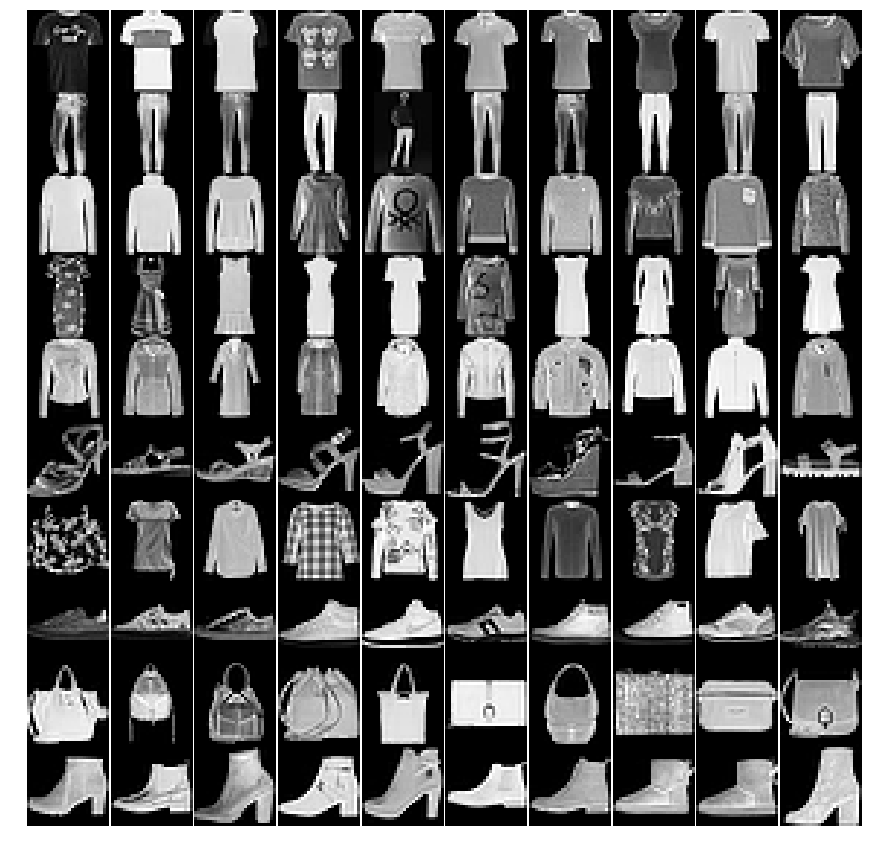

In [3]:
def dataset_info():
    dataset = FashionMNIST(dataset_folder, train=True, download=True)
    test_dataset = FashionMNIST(dataset_folder, train=False, download=True)
    
    print('Training dataset size is {}'.format(len(dataset)))
    print('Test dataset size is {}'.format(len(test_dataset)))
    
    def key_function(x):
        return x[1]

    num_of_classes = 10
    num_of_samples = 10

    figure, axis = plt.subplots(num_of_classes, num_of_samples, figsize=(15, 15))
    dataset = sorted(dataset, key=key_function)
    for group_ind, (key, group) in enumerate(itertools.groupby(dataset, key_function)):
        group = list(group)
        print('Class {} has {} elements in training dataset'.format(key, len(group)))
        
        random.shuffle(group)

        for element_ind, element in enumerate(group[:10]):
            current_axis = axis[group_ind, element_ind]

            current_axis.imshow(element[0], cmap='gray')
            current_axis.set_axis_off()

    figure.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    
dataset_info()

In [4]:
training_dataset = FashionMNIST(dataset_folder, train=True, download=True,
                                transform=torchvision.transforms.ToTensor())
test_dataset = FashionMNIST(dataset_folder, train=False, download=False,
                            transform=torchvision.transforms.ToTensor())

In [5]:
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 2, 5, padding=2)
        self.max_pooling1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(2, 4, 5, padding=2)
        self.max_pooling2 = nn.MaxPool2d(2)
        self.linear1 = torch.nn.Linear(7 * 7 * 4, 64)
        self.linear2 = torch.nn.Linear(64, 10)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = self.max_pooling1(x)
        x = nn.functional.relu(self.conv2(x))
        x = self.max_pooling2(x)
        x = x.view(-1, 7 * 7 * 4)
        x = nn.functional.relu(self.linear1(x))
        x = self.linear2(x)
        return x

Number of training parameters: 13514
===== HYPERPARAMETERS =====
batch_size = 100
epochs = 30
learning_rate = 0.001
Training loss after epoch #1 = 0.559
Training loss after epoch #2 = 0.510
Training loss after epoch #3 = 0.470
Training loss after epoch #4 = 0.426
Training loss after epoch #5 = 0.412
Training loss after epoch #6 = 0.400
Training loss after epoch #7 = 0.360
Training loss after epoch #8 = 0.409
Training loss after epoch #9 = 0.344
Training loss after epoch #10 = 0.330
Training loss after epoch #11 = 0.321
Training loss after epoch #12 = 0.308
Training loss after epoch #13 = 0.306
Training loss after epoch #14 = 0.312
Training loss after epoch #15 = 0.296
Training loss after epoch #16 = 0.288
Training loss after epoch #17 = 0.288
Training loss after epoch #18 = 0.281
Training loss after epoch #19 = 0.295
Training loss after epoch #20 = 0.275
Training loss after epoch #21 = 0.275
Training loss after epoch #22 = 0.269
Training loss after epoch #23 = 0.264
Training loss after

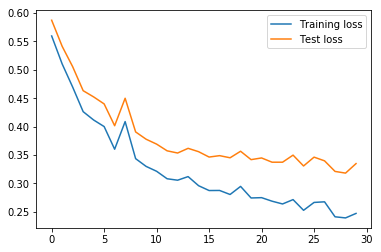

In [6]:
def average_loss(net, data, loss):
    total_loss = 0.0
    for inputs, labels in data:
        outputs = net(inputs)
        total_loss += loss(outputs, labels).item()

    return total_loss / len(data)


def visualize_training_curve(epochs_training_loss, epochs_test_loss):
    plt.clf()
    plt.plot(epochs_training_loss, label='Training loss')
    plt.plot(epochs_test_loss, label='Test loss')
    plt.legend()
    plt.show()

def train_net(net, batch_size, n_epochs, learning_rate, training_dataset, test_dataset):
    net_params_num = 0
    for param in net.parameters():
        net_params_num += param.numel()

    print('Number of training parameters:', net_params_num)

    header = '===== HYPERPARAMETERS ====='
    print(header)
    print('batch_size =', batch_size)
    print('epochs =', n_epochs)
    print('learning_rate =', learning_rate)
    print('=' * len(header))

    train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    epochs_training_loss = []
    epochs_test_loss = []
    training_start_time = time.time()

    for epoch in range(n_epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = net(inputs)

            loss_value = loss(outputs, labels)
            loss_value.backward()
            optimizer.step()

        training_loss_after_epoch = average_loss(net, train_loader, loss)
        test_loss_after_epoch = average_loss(net, test_loader, loss)
        print('Training loss after epoch #{} = {:.3f}'.format(epoch + 1, training_loss_after_epoch))
        epochs_training_loss.append(training_loss_after_epoch)
        epochs_test_loss.append(test_loss_after_epoch)

    print('Training has finished, took {:.2f}s'.format(time.time() - training_start_time))
    print('Training loss = {:.3f}'.format(epochs_training_loss[-1]))
    print('Test loss = {:.3f}'.format(epochs_test_loss[-1]))

    visualize_training_curve(epochs_training_loss, epochs_test_loss)
    
train_net(SimpleCNN(), 100, 30, 1e-3, training_dataset, test_dataset)